In [23]:
import tensorflow as tf
import numpy as np
import glob 
import os
import matplotlib.pyplot as plt

In [24]:
gpus = tf.config.experimental.list_physical_devices( device_type = 'GPU' )
# 设置该程序可见的GPU：写到最前面！
tf.config.experimental.set_visible_devices( devices = gpus[0:2], device_type = 'GPU' )

### 1. 导入所有文件的路径：

In [25]:
# 所有训练图片的地址：
train_path = glob.glob( '/home/gaoboyu/学习数据集/城市街景数据集/images/train/*/*.png' )
train_label_path = glob.glob( '/home/gaoboyu/学习数据集/城市街景数据集/gtFine/train/*/*labelIds.png' )

In [26]:
train_count = len(train_path)
len(train_path), len(train_label_path)

(2975, 2975)

In [27]:
# 所有验证图片的地址：
val_path = glob.glob( '/home/gaoboyu/学习数据集/城市街景数据集/images/val/*/*' )
val_label_path = glob.glob( '/home/gaoboyu/学习数据集/城市街景数据集/gtFine/val/*/*labelIds.png' )

In [28]:
val_count = len(val_path)
len(val_path), len(val_label_path)

(500, 500)

In [29]:
# 训练数据的乱序：
index = np.random.permutation( train_count )
train_path = np.array(train_path)[index]
train_label_path = np.array(train_label_path)[index]

In [30]:
type(train_path), len(train_path)

(numpy.ndarray, 2975)

### 2. 创建数据集：

In [31]:
train_dataset = tf.data.Dataset.from_tensor_slices( (train_path, train_label_path) )
val_dataset = tf.data.Dataset.from_tensor_slices( (val_path, val_label_path) )

In [32]:
train_dataset, val_dataset

(<TensorSliceDataset shapes: ((), ()), types: (tf.string, tf.string)>,
 <TensorSliceDataset shapes: ((), ()), types: (tf.string, tf.string)>)

### 3. 预处理函数：没有数据增强！

In [33]:
# 读取图片：3通道
def read_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels = 3)
    return img

# 读取标签：1通道（每个像素都是标签值）
def read_label(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels = 1)
    return img

In [34]:
# 预处理函数：改变数据类型！
def normal_image(image, label):
    # 对原图的处理：转换数据类型 + 归一化[-1,1]
    image = tf.cast(image, tf.float32)
    image = image / 127.5 - 1
    # 对标签图的处理：它的取值范围是[1,2,3]，但习惯于从0开始[0,1,2]！故都减去1
    label = tf.cast(label, tf.int16)
    return image, label

In [35]:
# 总加载函数：
new_height = 256
new_weight = 256

def load_image( image_path, label_path ):
    # 对原图的处理：
    image = read_image(image_path)
    image = tf.image.resize(image, (new_height, new_weight))  # 尺寸统一
    # 对标签图的处理：
    label = read_label(label_path)
    label = tf.image.resize(label, (new_height, new_weight))  # 尺寸统一
    
    return normal_image(image, label)

In [36]:
# 将数据应用于函数：
AUTOTUNE = tf.data.experimental.AUTOTUNE   # 多线程加载：图像加载是cpu处理的，cpu可以做多线程！

train_dataset = train_dataset.map( load_image, num_parallel_calls = AUTOTUNE )
val_dataset = val_dataset.map( load_image, num_parallel_calls = AUTOTUNE )

In [37]:
train_dataset, val_dataset

(<ParallelMapDataset shapes: ((256, 256, 3), (256, 256, 1)), types: (tf.float32, tf.int16)>,
 <ParallelMapDataset shapes: ((256, 256, 3), (256, 256, 1)), types: (tf.float32, tf.int16)>)

In [38]:
# 最后的乱序（让每个epoch的训练，看到的图像顺序不一样！）、batch划分：
BATCH_SIZE = 32  # 跟显存有关！
train_dataset = train_dataset.shuffle(train_count).repeat().batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)

In [39]:
# 查看最后的数据：
train_dataset, val_dataset

(<BatchDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 1)), types: (tf.float32, tf.int16)>,
 <BatchDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 1)), types: (tf.float32, tf.int16)>)

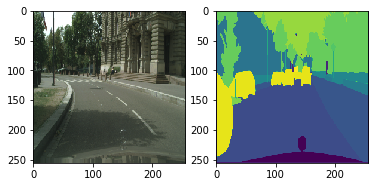

In [40]:
# 画图
# 画图最后查看一下：从tf.data.Dataset拿出的数据，都是Tensor的！而matplotlib中的绘图必须是array的！
# 不能放在这里，现在train_dataset里面都是地址！
for image, label in train_dataset.take(1):
    plt.subplot(1,2,1)
    plt.imshow( (image[0].numpy() + 1)/2 )
    plt.subplot(1,2,2)
    plt.imshow( label[0].numpy().reshape(new_height,new_weight) )

### 4. 自定义模型搭建：

In [51]:
OUTPUT_CHANNELS = 34

In [52]:
# 以后把模型的自定义，都写到一个函数里 正规！—— 没有输入数据，返回一个模型！—— 层的生成，完全可以用循环！
def create_model():
    inputs = tf.keras.layers.Input( shape = (256,256,3) )  # 所有的层都是大写的！所有这也是一个层！
    
    # 前半部分卷积基自定义：顺序连接 + 用名字获得某层输出
    # 第一部分：_1
    conv2d_1_1 = tf.keras.layers.Conv2D( 64, (3,3), padding = 'same', activation = 'relu', name = 'conv2d_1_1' )(inputs)
    bn_1_1 = tf.keras.layers.BatchNormalization( name = 'bn_1_1' )(conv2d_1_1)
    conv2d_1_2 = tf.keras.layers.Conv2D( 64, (3,3), padding = 'same', activation = 'relu', name = 'conv2d_1_2' )(bn_1_1)
    bn_1_2 = tf.keras.layers.BatchNormalization( name = 'bn_1_2' )(conv2d_1_2)  # 256 x 256 x 64 √
    maxpool_1_1 = tf.keras.layers.MaxPooling2D( name = 'maxpool_1_1' )(bn_1_2)  # 128 x 128 x 64
    
    # 第二部分：_2
    conv2d_2_1 = tf.keras.layers.Conv2D( 128, (3,3), padding = 'same', activation = 'relu', name = 'conv2d_2_1' )(maxpool_1_1)
    bn_2_1 = tf.keras.layers.BatchNormalization( name = 'bn_2_1' )(conv2d_2_1)
    conv2d_2_2 = tf.keras.layers.Conv2D( 128, (3,3), padding = 'same', activation = 'relu', name = 'conv2d_2_2' )(bn_2_1)
    bn_2_2 = tf.keras.layers.BatchNormalization( name = 'bn_2_2' )(conv2d_2_2)  # 128 x 128 x 128 √
    maxpool_2_1 = tf.keras.layers.MaxPooling2D( name = 'maxpool_2_1' )(bn_2_2)  # 64 x 64 x 128
    
    # 第三部分：_3
    conv2d_3_1 = tf.keras.layers.Conv2D( 256, (3,3), padding = 'same', activation = 'relu', name = 'conv2d_3_1' )(maxpool_2_1)
    bn_3_1 = tf.keras.layers.BatchNormalization( name = 'bn_3_1' )(conv2d_3_1)
    conv2d_3_2 = tf.keras.layers.Conv2D( 256, (3,3), padding = 'same', activation = 'relu', name = 'conv2d_3_2' )(bn_3_1)
    bn_3_2 = tf.keras.layers.BatchNormalization( name = 'bn_3_2' )(conv2d_3_2)  # 64 x 64 x 256 √
    maxpool_3_1 = tf.keras.layers.MaxPooling2D( name = 'maxpool_3_1' )(bn_3_2)  # 32 x 32 x 256
    
    # 第四部分：_4
    conv2d_4_1 = tf.keras.layers.Conv2D( 512, (3,3), padding = 'same', activation = 'relu', name = 'conv2d_4_1' )(maxpool_3_1)
    bn_4_1 = tf.keras.layers.BatchNormalization( name = 'bn_4_1' )(conv2d_4_1)
    conv2d_4_2 = tf.keras.layers.Conv2D( 512, (3,3), padding = 'same', activation = 'relu', name = 'conv2d_4_2' )(bn_4_1)
    bn_4_2 = tf.keras.layers.BatchNormalization( name = 'bn_4_2' )(conv2d_4_2)  # 32 x 32 x 512 √
    maxpool_4_1 = tf.keras.layers.MaxPooling2D( name = 'maxpool_4_1' )(bn_4_2)  # 16 x 16 x 512  
    
    # 第五部分：_5 —— 最后没下采样！
    conv2d_5_1 = tf.keras.layers.Conv2D( 1024, (3,3), padding = 'same', activation = 'relu', name = 'conv2d_5_1' )(maxpool_4_1)
    bn_5_1 = tf.keras.layers.BatchNormalization( name = 'bn_5_1' )(conv2d_5_1)
    conv2d_5_2 = tf.keras.layers.Conv2D( 1024, (3,3), padding = 'same', activation = 'relu', name = 'conv2d_5_2' )(bn_5_1)
    bn_5_2 = tf.keras.layers.BatchNormalization( name = 'bn_5_2' )(conv2d_5_2)  # 16 x 16 x 1024
    
    
    # 后半部分自定义：反卷积 + 跳接（带√的）
    
    # 第一部分：x1、x2
    # 上采样：上采用的卷积核是(2,2)
    x1 = tf.keras.layers.Conv2DTranspose( 512, (2,2), strides = 2, activation = 'relu', padding = 'same', name = 'x1')(bn_5_2)
    bn_x1 = tf.keras.layers.BatchNormalization( name = 'bn_x1' )(x1)  # 32 x 32 x 512
    # 跳接合并：当成一个层！
    x2 = tf.concat( [bn_x1, bn_4_2], axis = -1 )  # 32 x 32 x (512+512) = 32 x 32 x 1024
    conv2d_x2_1 = tf.keras.layers.Conv2D( 512, (3,3), padding = 'same', activation = 'relu', name = 'conv2d_x2_1' )(x2)
    bn_x2_1 = tf.keras.layers.BatchNormalization( name = 'bn_x2_1' )(conv2d_x2_1)
    conv2d_x2_2 = tf.keras.layers.Conv2D( 512, (3,3), padding = 'same', activation = 'relu', name = 'conv2d_x2_2' )(bn_x2_1)
    bn_x2_2 = tf.keras.layers.BatchNormalization( name = 'bn_x2_2' )(conv2d_x2_2)  # 32 x 32 x 512
    
    # 第二部分：x3、x4
    # 上采样：上采用的卷积核是(2,2)
    x3 = tf.keras.layers.Conv2DTranspose( 256, (2,2), strides = 2, activation = 'relu', padding = 'same', name = 'x3')(bn_x2_2)
    bn_x3 = tf.keras.layers.BatchNormalization( name = 'bn_x3' )(x3)  # 64 x 64 x 256
    # 跳接合并：当成一个层！
    x4 = tf.concat( [bn_x3, bn_3_2], axis = -1 )  # 64 x 64 x (256+256) = 64 x 64 x 512
    conv2d_x4_1 = tf.keras.layers.Conv2D( 256, (3,3), padding = 'same', activation = 'relu', name = 'conv2d_x4_1' )(x4)
    bn_x4_1 = tf.keras.layers.BatchNormalization( name = 'bn_x4_1' )(conv2d_x4_1)
    conv2d_x4_2 = tf.keras.layers.Conv2D( 256, (3,3), padding = 'same', activation = 'relu', name = 'conv2d_x4_2' )(bn_x4_1)
    bn_x4_2 = tf.keras.layers.BatchNormalization( name = 'bn_x4_2' )(conv2d_x4_2)  # 64 x 64 x 256
    
    # 第三部分：x5、x6
    # 上采样：上采用的卷积核是(2,2)
    x5 = tf.keras.layers.Conv2DTranspose( 128, (2,2), strides = 2, activation = 'relu', padding = 'same', name = 'x5')(bn_x4_2)
    bn_x5 = tf.keras.layers.BatchNormalization( name = 'bn_x5' )(x5)  # 128 x 128 x 128
    # 跳接合并：当成一个层！
    x6 = tf.concat( [bn_x5, bn_2_2], axis = -1 )  # 128 x 128 x (128+128) = 128 x 128 x 256
    conv2d_x6_1 = tf.keras.layers.Conv2D( 128, (3,3), padding = 'same', activation = 'relu', name = 'conv2d_x6_1' )(x6)
    bn_x6_1 = tf.keras.layers.BatchNormalization( name = 'bn_x6_1' )(conv2d_x6_1)
    conv2d_x6_2 = tf.keras.layers.Conv2D( 128, (3,3), padding = 'same', activation = 'relu', name = 'conv2d_x6_2' )(bn_x6_1)
    bn_x6_2 = tf.keras.layers.BatchNormalization( name = 'bn_x6_2' )(conv2d_x6_2)  # 128 x 128 x 128
    
    # 第四部分：x7、x8
    # 上采样：上采用的卷积核是(2,2)
    x7 = tf.keras.layers.Conv2DTranspose( 64, (2,2), strides = 2, activation = 'relu', padding = 'same', name = 'x7' )(bn_x6_2)
    bn_x7 = tf.keras.layers.BatchNormalization( name = 'bn_x7' )(x7)  # 256 x 256 x 64
    # 跳接合并：当成一个层！
    x8 = tf.concat( [bn_x7, bn_1_2], axis = -1 )  # 256 x 256 x (64+64) = 256 x 256 x 128
    conv2d_x8_1 = tf.keras.layers.Conv2D( 64, (3,3), padding = 'same', activation = 'relu', name = 'conv2d_x8_1' )(x8)
    bn_x8_1 = tf.keras.layers.BatchNormalization( name = 'bn_x8_1' )(conv2d_x8_1)
    conv2d_x8_2 = tf.keras.layers.Conv2D( 64, (3,3), padding = 'same', activation = 'relu', name = 'conv2d_x8_2' )(bn_x8_1)
    bn_x8_2 = tf.keras.layers.BatchNormalization( name = 'bn_x8_2' )(conv2d_x8_2)  # 256 x 256 x 64
    
    # 最后的通道数变为34：卷积核为(1,1)；激活函数用softmax
    # 最后输出大小：256 x 256 x 34
    output = tf.keras.layers.Conv2D(34, kernel_size = (1,1), strides = (1,1), padding = 'same', activation = 'softmax', name = 'output')(bn_x8_2)
    
    # 模型搭建：
    model = tf.keras.Model( inputs = inputs, outputs = output )
    return model 

In [53]:
model = create_model()

### 5. 模型编译和训练：

In [55]:
# 模型编译
model.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['acc']  # 类别太多了！如果只有几个类的话，IoU的结果会非常好！
)

In [56]:
# 定义保存模型的回调函数：保存整个模型、只保存最好的！
# 设置保存的路径：
checkpoint_path = '/home/gaoboyu/学习保存的模型/Unet'
# 设置回调函数保存模型：没设置的参数都默认
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_path,
    monitor = 'val_acc',
    save_best_only = True  # 监控的目标：如果新的epoch结果比前一个要好，那就重新保存最新的，删掉旧的！
)

In [57]:
# 模型训练
EPOCHES = 10
history = model.fit(
    train_dataset,
    epochs = EPOCHES,
    steps_per_epoch = train_count // BATCH_SIZE,
    validation_data = val_dataset,
    validation_steps = val_count // BATCH_SIZE,
    callbacks = [cp_callback]
)

Epoch 1/10
 10/185 [>.............................] - ETA: 4:05 - loss: 3.0471 - acc: 0.3038

KeyboardInterrupt: 

### 6. 模型导入：